In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

from sklearn.tree import export_graphviz
from IPython.display import Image

import datetime


calls = pd.read_csv("./data/calls.csv",parse_dates=["DateStart", "TimeStart"])
reasons = pd.read_csv("./data/reasons.csv")



#preprocess the calls dataset
#calls = calls[["callreportnum","DateStart","TimeStart","CityName","ContactMethod","CallLength"]]
calls['TimeStart'] = calls['TimeStart'].dt.time
calls.loc[calls["CityName"].isna(),"CityName"] = "Unknown"


calls["year"] = pd.to_datetime(calls["DateStart"]).dt.strftime("%Y")
calls

C:\Users\16044\AppData\Local\Temp\ipykernel_21404\1334548706.py:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  calls = pd.read_csv("./data/calls.csv",parse_dates=["DateStart", "TimeStart"])


,Unnamed: 0,callreportnum,DateStart,TimeStart,DateEnd,TimeEnd,CallLength,CityName,CallType,ContactMethod,CallerDemographicsGender,CallerDemographicsAgeGroup,CallerDemographicsCallerType,CallerTypeAffected3rdParty,CallerDemographicsInterpretationLanguage,CallerDemographicsInterpretationOtherlanguage,PublicityOtherPublicity,year
0,1,54694316.0,2018-07-16,16:42:00,2018-07-16,1899-12-31 16:51:00,9,New Westminster,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Not Obtained,2018
1,2,54694245.0,2018-07-16,16:39:00,2018-07-16,1899-12-31 17:07:00,28,unknown,Assessment and Referral,Text Message,Unknown,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2018
2,3,54693989.0,2018-07-16,16:27:00,2018-07-16,1899-12-31 16:37:00,10,Winnipeg,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2018
3,4,54693908.0,2018-07-16,16:23:00,2018-07-16,1899-12-31 16:26:00,3,Burnaby,Assessment and Referral,Telephone,Female,19-54 Adult,Service Provider,NaN,NaN,NaN,Not Obtained,2018
4,5,54693150.0,2018-07-16,15:54:00,2018-07-16,1899-12-31 15:56:00,2,Vancouver,Assessment and Referral,Telephone,Male,19-54 Adult,Individual,NaN,NaN,NaN,Repeat Caller,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237721,237722,110115364.0,2022-12-07,15:34:00,2022-12-07,1899-12-31 15:58:00,24,Vancouver,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2022
237722,237723,110115194.0,2022-12-07,15:30:00,2022-12-07,1899-12-31 15:38:00,8,Duncan,Assessment and Referral,Telephone,Female,65+ Senior,Individual,NaN,NaN,NaN,Not Obtained,2022
237723,237724,110115107.0,2022-12-07,15:28:00,2022-12-07,1899-12-31 15:35:00,7,Vancouver,Assessment and Referral,Telephone,Male,65+ Senior,Individual,NaN,NaN,NaN,Not Obtained,2022
237724,237725,110114724.0,2022-12-07,15:19:00,2022-12-07,1899-12-31 15:21:00,2,Vancouver,Assessment and Referral,Telephone,Male,65+ Senior,Service Provider,NaN,NaN,NaN,Service Provider,2022


In [2]:

#has the vars that we can use to predict call duration, know imediately when call starts
calls_simple =  pd.read_csv("preprocessed/calls_prep.csv")
calls_simple = calls_simple[["callreportnum","CityName","ContactMethod","AbsoluteTime","TimeofYear","TimeofDay","CallLength","CityNameCode","ContactMethod_code"]]
calls_simple

,callreportnum,CityName,ContactMethod,AbsoluteTime,TimeofYear,TimeofDay,CallLength,CityNameCode,ContactMethod_code
0,54694316.0,New Westminster,Telephone,1.531759e+09,16965720.0,34920.0,9,0,0
1,54694245.0,unknown,Text Message,1.531759e+09,16965540.0,34740.0,28,1,1
2,54693989.0,Winnipeg,Telephone,1.531758e+09,16964820.0,34020.0,10,2,0
3,54693908.0,Burnaby,Telephone,1.531758e+09,16964580.0,33780.0,3,3,0
4,54693150.0,Vancouver,Telephone,1.531756e+09,16962840.0,32040.0,2,4,0
...,...,...,...,...,...,...,...,...,...
237721,110115364.0,Vancouver,Telephone,1.670427e+09,29403240.0,27240.0,24,4,0
237722,110115194.0,Duncan,Telephone,1.670427e+09,29403000.0,27000.0,8,29,0
237723,110115107.0,Vancouver,Telephone,1.670427e+09,29402880.0,26880.0,7,4,0
237724,110114724.0,Vancouver,Telephone,1.670426e+09,29402340.0,26340.0,2,4,0


In [3]:
#get average call per annual

years = list(calls["year"].unique())
avg_year = calls.groupby('year')[['CallLength']].mean()

avg_year

,CallLength
year,
2018,5.061218
2019,5.057681
2020,6.131834
2021,6.592357
2022,8.138918


#### distribution of call length, ignoring calls over 30 mins length

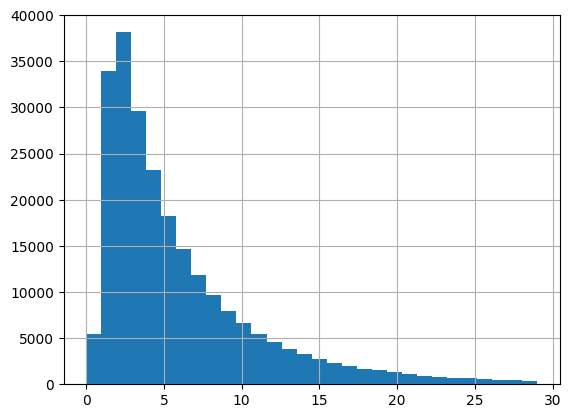

In [4]:
call_len_hist =calls_simple[calls_simple["CallLength"]<30]["CallLength"].hist(bins=30)

In [5]:
calls_year_avgs = calls.groupby('year')[['CallLength']].count()
calls_year_avgs


,CallLength
year,
2018,48940
2019,46497
2020,45542
2021,52649
2022,44098


In [6]:
calls_simple[calls_simple["CallLength"]>50]

for i in range(10,150,10):
    temp = calls_simple.loc[(calls_simple["CallLength"]>i)]
    print("There are ",len(temp), "calls of length greater than ", i)


There are  38211 calls of length greater than  10
There are  9572 calls of length greater than  20
There are  3177 calls of length greater than  30
There are  1227 calls of length greater than  40
There are  544 calls of length greater than  50
There are  247 calls of length greater than  60
There are  130 calls of length greater than  70
There are  63 calls of length greater than  80
There are  34 calls of length greater than  90
There are  22 calls of length greater than  100
There are  18 calls of length greater than  110
There are  13 calls of length greater than  120
There are  7 calls of length greater than  130
There are  6 calls of length greater than  140


In [7]:
CityName_stats = calls_simple[["CityName","CallLength"]].groupby("CityName").mean()
CityName_stats["count"] = pd.Series(calls_simple[["CityName","CallLength"]].groupby("CityName").count()["CallLength"])
CityName_stats.sort_values(["count"],ascending=False).tail(100)

,CallLength,count
CityName,,
Jasper,11.0,1
Bonnyville,3.0,1
Kemano,6.0,1
Dease Lake,7.0,1
Kildonan,3.0,1
...,...,...
Bridesville,10.0,1
Opasatika,6.0,1
Oyster Bay,8.0,1


In [8]:
total = sum(CityName_stats['count'])
test = sum(CityName_stats[CityName_stats['count'] > 500]["count"])
test/total

#len(CityName_stats[CityName_stats['count'] > 500])


0.9420004543045355

In [9]:
ratio = 0.8
 
total_rows = calls.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
#train = calls_simple[0:train_size]
#test = calls_simple[train_size:]

#for now all data is test

test = calls.copy()

test

,Unnamed: 0,callreportnum,DateStart,TimeStart,DateEnd,TimeEnd,CallLength,CityName,CallType,ContactMethod,CallerDemographicsGender,CallerDemographicsAgeGroup,CallerDemographicsCallerType,CallerTypeAffected3rdParty,CallerDemographicsInterpretationLanguage,CallerDemographicsInterpretationOtherlanguage,PublicityOtherPublicity,year
0,1,54694316.0,2018-07-16,16:42:00,2018-07-16,1899-12-31 16:51:00,9,New Westminster,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Not Obtained,2018
1,2,54694245.0,2018-07-16,16:39:00,2018-07-16,1899-12-31 17:07:00,28,unknown,Assessment and Referral,Text Message,Unknown,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2018
2,3,54693989.0,2018-07-16,16:27:00,2018-07-16,1899-12-31 16:37:00,10,Winnipeg,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2018
3,4,54693908.0,2018-07-16,16:23:00,2018-07-16,1899-12-31 16:26:00,3,Burnaby,Assessment and Referral,Telephone,Female,19-54 Adult,Service Provider,NaN,NaN,NaN,Not Obtained,2018
4,5,54693150.0,2018-07-16,15:54:00,2018-07-16,1899-12-31 15:56:00,2,Vancouver,Assessment and Referral,Telephone,Male,19-54 Adult,Individual,NaN,NaN,NaN,Repeat Caller,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237721,237722,110115364.0,2022-12-07,15:34:00,2022-12-07,1899-12-31 15:58:00,24,Vancouver,Assessment and Referral,Telephone,Female,19-54 Adult,Individual,NaN,NaN,NaN,Service Provider,2022
237722,237723,110115194.0,2022-12-07,15:30:00,2022-12-07,1899-12-31 15:38:00,8,Duncan,Assessment and Referral,Telephone,Female,65+ Senior,Individual,NaN,NaN,NaN,Not Obtained,2022
237723,237724,110115107.0,2022-12-07,15:28:00,2022-12-07,1899-12-31 15:35:00,7,Vancouver,Assessment and Referral,Telephone,Male,65+ Senior,Individual,NaN,NaN,NaN,Not Obtained,2022
237724,237725,110114724.0,2022-12-07,15:19:00,2022-12-07,1899-12-31 15:21:00,2,Vancouver,Assessment and Referral,Telephone,Male,65+ Senior,Service Provider,NaN,NaN,NaN,Service Provider,2022


# Model: Try guessing the year avg

In [10]:
#guess the time based on year avg
test["prediction"] = test["year"].map(lambda x: avg_year.loc[x,"CallLength"])


In [11]:
def check_validity(test_df):
    check_df = test_df.copy()

    check_df["Correct"] = False

    for c in check_df.index:
        truth = check_df.loc[c,"CallLength"]
        pred = check_df.loc[c,"prediction"]

        if pred < (truth + 1) and pred > truth - 1:
             check_df.loc[c,"Correct"] = True
        
    check_df = check_df.groupby("Correct")[["CallLength"]].count()
    print("The accuracy is ",100*check_df.loc[True,"CallLength"]/sum(check_df.loc[:,"CallLength"]), "percent if it just has to be within 1 min. ")
    rmse = mean_squared_error(test['CallLength'], test['prediction'], squared=False)
    print("The rmse is: ", rmse)
    return check_df

check_validity(test)




The accuracy is  11.666792862370965 percent if it just has to be within 1 min. 
The rmse is:  7.120056000998193


,CallLength
Correct,
False,209991
True,27735


# Model: Guess is the City's Average Call length

In [12]:
# Model: Try guessing the year avg
test["guess"] = test["CityName"].map(lambda x: CityName_stats.loc[x,"CallLength"])

In [13]:
check_validity(test)

The accuracy is  11.666792862370965 percent if it just has to be within 1 min. 
The rmse is:  7.120056000998193


,CallLength
Correct,
False,209991
True,27735


# Random Forest 

In [14]:

# #add code to each city
# city_to_code = pd.DataFrame(calls_simple["CityName"].unique())
# city_to_code["code"] = pd.Series(range(0,514))
# city_to_code.columns = ["CityName","code"]


# calls_simple["CityNameCode"] = calls_simple["CityName"].map(lambda x: city_to_code.loc[city_to_code["CityName"] == x,"code"].iloc[0] )

# #turn contact methods into code

# #convert na to contactMethod
# calls_simple.loc[calls_simple["ContactMethod"].isna(),"ContactMethod"] = "Unknown"

# contactMethod_to_code = pd.DataFrame(calls_simple["ContactMethod"].unique())

# contactMethod_to_code["code"]=  pd.Series(range(0,8))
# contactMethod_to_code.columns = ["ContactMethod","code"]
# calls_simple["ContactMethod_code"] = calls_simple["ContactMethod"].map(lambda x: contactMethod_to_code.loc[contactMethod_to_code["ContactMethod"] == x,"code"].iloc[0] )


#convert call
#datetime.datetime.combine(calls_simple["DateStart"][0],calls_simple["TimeStart"][0])
calls_simple


,callreportnum,CityName,ContactMethod,AbsoluteTime,TimeofYear,TimeofDay,CallLength,CityNameCode,ContactMethod_code
0,54694316.0,New Westminster,Telephone,1.531759e+09,16965720.0,34920.0,9,0,0
1,54694245.0,unknown,Text Message,1.531759e+09,16965540.0,34740.0,28,1,1
2,54693989.0,Winnipeg,Telephone,1.531758e+09,16964820.0,34020.0,10,2,0
3,54693908.0,Burnaby,Telephone,1.531758e+09,16964580.0,33780.0,3,3,0
4,54693150.0,Vancouver,Telephone,1.531756e+09,16962840.0,32040.0,2,4,0
...,...,...,...,...,...,...,...,...,...
237721,110115364.0,Vancouver,Telephone,1.670427e+09,29403240.0,27240.0,24,4,0
237722,110115194.0,Duncan,Telephone,1.670427e+09,29403000.0,27000.0,8,29,0
237723,110115107.0,Vancouver,Telephone,1.670427e+09,29402880.0,26880.0,7,4,0
237724,110114724.0,Vancouver,Telephone,1.670426e+09,29402340.0,26340.0,2,4,0


In [15]:
#runs randomForest on the parameters of our choice
def runRandomForest(n_estimators, calls_df, parameterNames,goalName = ["CallLength"]):

    #make trianing and test sets
    calls_df = calls_df.sample(frac=1)
   
    trainx = calls_df[0:train_size][parameterNames]
    trainy = calls_df[0:train_size][goalName]
    testx = calls_df[train_size:][parameterNames]
    tesy = calls_df[train_size:][goalName]

    sel = RandomForestClassifier(n_estimators = n_estimators)
    sel.fit(trainx,np.ravel(trainy)) 

    y_pred = sel.predict(testx)
    
    accuracy = accuracy_score(tesy, y_pred)
    print("Accuracy:", accuracy, "n:",n_estimators, "input parameters:",parameterNames)
    

### Trying different n and different input parameters

First try n = [100,150,200,300] with these input parameters: [["CityNameCode"],["year","CityNameCode"],["CityNameCode"]]


In [16]:

different_n = [100,150,200,300]
parameters_input = [["CityNameCode"],["year","CityNameCode"],["CityNameCode"]]

for n in different_n:
    for p in parameters_input:
        runRandomForest(n,calls_simple,p)

Accuracy: 0.16825810793757623 n: 100 input parameters: ['CityNameCode']
Accuracy: 0.17181256046775753 n: 100 input parameters: ['year', 'CityNameCode']
Accuracy: 0.17229630252807807 n: 100 input parameters: ['CityNameCode']
Accuracy: 0.16882597905186555 n: 150 input parameters: ['CityNameCode']
Accuracy: 0.17101333445505404 n: 150 input parameters: ['year', 'CityNameCode']
Accuracy: 0.17010894712488958 n: 150 input parameters: ['CityNameCode']
Accuracy: 0.1685104950994826 n: 200 input parameters: ['CityNameCode']
Accuracy: 0.1734951415471333 n: 200 input parameters: ['year', 'CityNameCode']
Accuracy: 0.1713919151979136 n: 200 input parameters: ['CityNameCode']
Accuracy: 0.1685315273629748 n: 300 input parameters: ['CityNameCode']
Accuracy: 0.17183359273124973 n: 300 input parameters: ['year', 'CityNameCode']
Accuracy: 0.16832120472805284 n: 300 input parameters: ['CityNameCode']


n: 200 input parameters: ['year', 'CityNameCode'] performed the best

# n = [100,150,200,300], ["year","CityNameCode","ContactMethod_code"]

Best Performing: Accuracy: 0.17803811046144785 n: 200 input parameters: ['year', 'CityNameCode', 'ContactMethod_code']


In [17]:

different_n = [100,150,200,300]
parameters_input = [["year","CityNameCode","ContactMethod_code"]]

for n in different_n:
    for p in parameters_input:
        runRandomForest(n,calls_simple,p)

Accuracy: 0.1762503680646111 n: 100 input parameters: ['year', 'CityNameCode', 'ContactMethod_code']
Accuracy: 0.17519875489000125 n: 150 input parameters: ['year', 'CityNameCode', 'ContactMethod_code']
Accuracy: 0.17667101333445506 n: 200 input parameters: ['year', 'CityNameCode', 'ContactMethod_code']
Accuracy: 0.17448365793126655 n: 300 input parameters: ['year', 'CityNameCode', 'ContactMethod_code']


In [118]:
calls_simple

,callreportnum,CityName,ContactMethod,AbsoluteTime,TimeofYear,TimeofDay,CallLength
0,54694316.0,New Westminster,Telephone,1.531759e+09,16965720.0,34920.0,9
1,54694245.0,unknown,Text Message,1.531759e+09,16965540.0,34740.0,28
2,54693989.0,Winnipeg,Telephone,1.531758e+09,16964820.0,34020.0,10
3,54693908.0,Burnaby,Telephone,1.531758e+09,16964580.0,33780.0,3
4,54693150.0,Vancouver,Telephone,1.531756e+09,16962840.0,32040.0,2
...,...,...,...,...,...,...,...
237721,110115364.0,Vancouver,Telephone,1.670427e+09,29403240.0,27240.0,24
237722,110115194.0,Duncan,Telephone,1.670427e+09,29403000.0,27000.0,8
237723,110115107.0,Vancouver,Telephone,1.670427e+09,29402880.0,26880.0,7
237724,110114724.0,Vancouver,Telephone,1.670426e+09,29402340.0,26340.0,2


In [16]:
different_n = [100,150,200]
parameters_input = [["TimeofYear","TimeofDay","ContactMethod_code","CityNameCode"]]

for n in different_n:
    for p in parameters_input:
        runRandomForest(n,calls_simple,p)

# Trying random forest only on actual calls
Seems slightly better only


In [19]:
different_n = [100,150,200,300]
parameters_input = [["year","CityNameCode"]]

for n in different_n:
    for p in parameters_input:
        runRandomForest(n,calls_simple[calls_simple["ContactMethod"] == "Telephone"].copy(),p)

Accuracy: 0.17673999278759467 n: 100 input parameters: ['year', 'CityNameCode']
Accuracy: 0.17432383699963938 n: 150 input parameters: ['year', 'CityNameCode']
Accuracy: 0.17601875225387667 n: 200 input parameters: ['year', 'CityNameCode']
Accuracy: 0.17706455102776775 n: 300 input parameters: ['year', 'CityNameCode']
